#### GLM. Обобщение линейных моделей

Для прогнозирования среднего значения выходной переменной можно применить произвольно выбранную функцию к линейной комбинации входной переменной:

$$\mu=f(\alpha+X\beta)$$

где f - функция обратной связи (inverse link function)

Одним из случаев, когда требуется использование функции обратной связи, является работа с категориальными переменными, такими как обозначение цвета, пол, биологические виды или политические партии/принадлежность к ним. Ни одну из таких переменных невозможно правильно смоделировать с помощью нормального распределения.

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext watermark
%watermark --iversions

pymc3     : 3.10.0
seaborn   : 0.10.0
arviz     : 0.11.1
numpy     : 1.19.2
pandas    : 1.1.4
matplotlib: 3.3.3
scipy     : 1.5.2



#### Logistic regression

In [3]:
iris = pd.read_csv('data/iris.csv')
iris.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

Рассмотрим данные

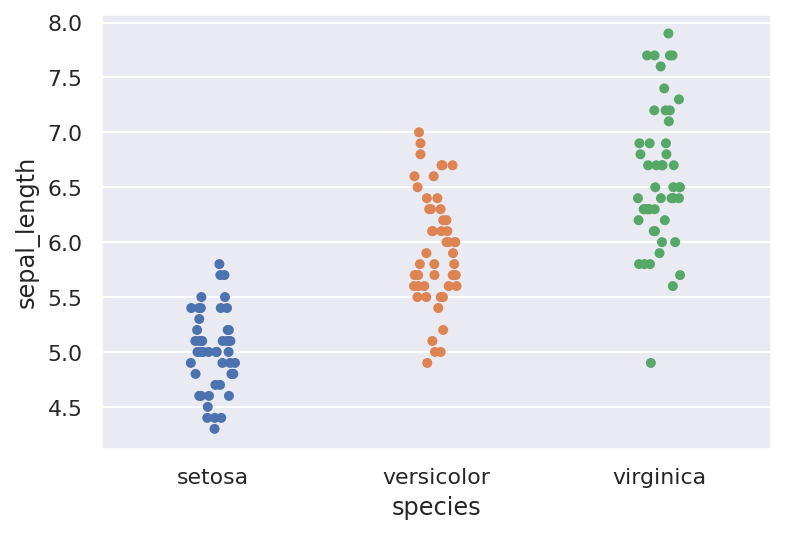

In [4]:
sns.stripplot(x='species', y='sepal_length', data=iris, jitter=True)
plt.show()

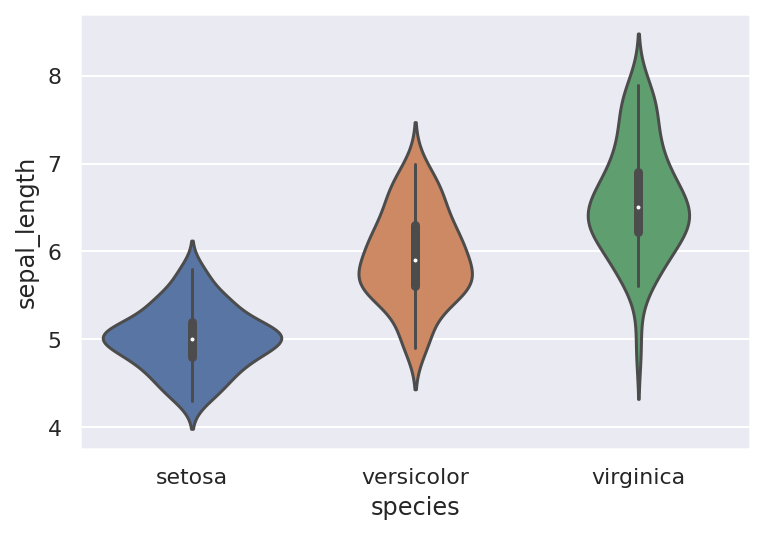

In [5]:
sns.violinplot(x='species', y='sepal_length', data=iris)
plt.show()

In [6]:
sns.pairplot(iris, hue='species', diag_kind='kde')
plt.show()

Пример с бинарной классификацией

In [7]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length'
x_0 = df[x_n].values
# Центрирование данных помогает семплирванию
x_c = x_0-x_0.mean()

In [8]:
with pm.Model() as model_0:
    
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    # Linear combination
    mu = alpha + pm.math.dot(x_c, beta)
    # Sigmoid function
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    # Decision boundary
    bd = pm.Deterministic('bd', -alpha/beta)
    
    # Likelihood
    yl = pm.Bernoulli('yl', p=theta, observed=y_0)
    
    trace_0 = pm.sample(1000)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [9]:
az.summary(trace_0, var_names=['alpha', 'beta', 'bd'])

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha  0.302  0.341  -0.328    0.944      0.006    0.005    3048.0  2190.0   
beta   5.373  1.069   3.484    7.366      0.020    0.015    2759.0  2628.0   
bd    -0.055  0.062  -0.169    0.064      0.001    0.001    3081.0  2464.0   

       ess_bulk  ess_tail  r_hat  
alpha    3072.0    2372.0    1.0  
beta     2818.0    2197.0    1.0  
bd       3086.0    2547.0    1.0

In [10]:
az.plot_trace(trace_0, var_names=['alpha', 'beta', 'bd'])

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'bd'}>,
        <AxesSubplot:title={'center':'bd'}>]], dtype=object)

Рассмотрим итоговые сигмоиду и decision boundary

In [11]:
theta = trace_0['theta'].mean(axis=0)
idx = np.argsort(x_c)

fig = plt.figure(figsize=(8,6))
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)

plt.vlines(trace_0['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hpd(trace_0['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_0, 0.02),
marker='.', color=[f'C{x}' for x in y_0])
az.plot_hpd(x_c, trace_0['theta'], color='C2')

plt.xlabel(x_n)
plt.ylabel('theta', rotation=0)
# Use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1))
plt.show()

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/stats/stats.py:341: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


#### Множественная логистическая регрессия

В данном случае boundary decision - уже прямая линия. По существу - это гиперплоскость соответствующего признакового пространства.
рассчитывается исходя из определения равенства логистической функции 0.5 при нулевых значениях признаков.

In [12]:
df = iris.query("species == ('setosa', 'versicolor')")
y_1 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width']
x_1 = df[x_n].values

In [13]:
with pm.Model() as model_1:
    
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    mu = alpha + pm.math.dot(x_1, beta)
    
    theta = pm.Deterministic('theta', 1/(1+pm.math.exp(-mu)))
    bd = pm.Deterministic('bd', 
                          -alpha/beta[1] - (beta[0]/beta[1]*x_1[:, 0])
                         )
    yl = pm.Bernoulli('yl', p=theta, observed=y_1)
    
    trace_1 = pm.sample(2000)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [14]:
az.summary(trace_1, var_names=['alpha', 'beta'])

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha   -9.254  4.773 -18.024   -0.227      0.106    0.075    2018.0  2018.0   
beta[0]  4.705  0.918   3.095    6.463      0.022    0.015    1809.0  1809.0   
beta[1] -5.209  1.005  -7.004   -3.352      0.020    0.014    2543.0  2540.0   

         ess_bulk  ess_tail  r_hat  
alpha      2028.0    2130.0    1.0  
beta[0]    1744.0    1374.0    1.0  
beta[1]    2508.0    1963.0    1.0

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


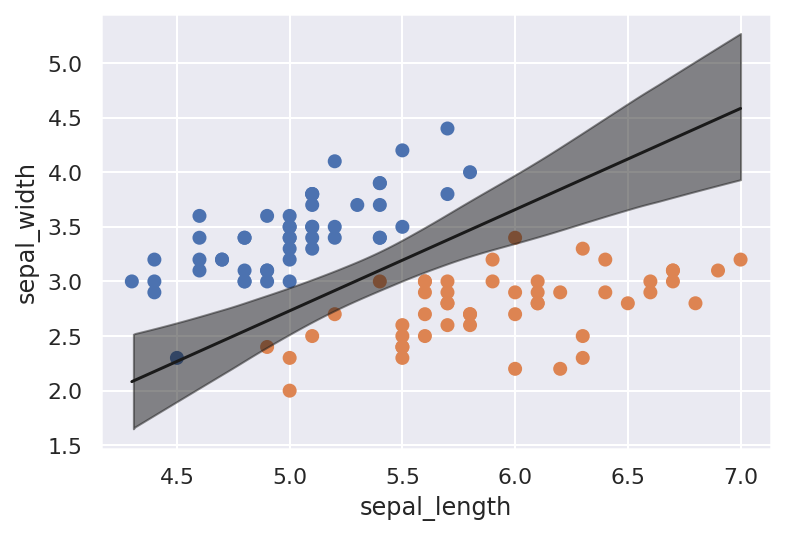

In [15]:
idx = np.argsort(x_1[:,0])
bd = trace_1['bd'].mean(0)[idx]
plt.scatter(x_1[:,0], x_1[:,1], c=[f'C{x}' for x in y_0])
plt.plot(x_1[:,0][idx], bd, color='k');
az.plot_hpd(x_1[:,0], trace_1['bd'], color='k')

plt.xlabel(x_n[0])
plt.ylabel(x_n[1])
plt.show()

Явная кривизна является результатом наличия нескольких линий, вращающихся относительно центральной области (приближенно: относительно среднего значения x и среднего значения y).

#### Интерпретация коэффициентов

Интерпретацию логистической регрессии можно вывести относительно понятия шансов:

Знаем, что:
$$odds_i = \frac{P_i}{1-P_i}$$
$$P_i=P(y=1)=\frac{e^{x\beta}}{1+e^{X\beta}}$$
$$P_i=P(y=0)=1-P(y=1)=\frac{1}{1+e^{X\beta}}$$

Соответственно:
$$odds_i = \frac{P_i}{1-P_i}=e^{X\beta}$$\
$$ln(\frac{P(y=1)}{1-P(y=1)})=X\beta$$

А значит:
$$odds_i=e^{beta_1}(e^{\beta_2 X_i2 })...(e^{\beta_k X_ik})$$

$$\frac{odds_i(X_m + 1)}{odds_i(X_m)}=e^{\beta_m}$$

Т.е. формально, при увеличении X_m на 1 единицу при прочих равных условиях шансы изменятся в $e^{\beta_m} раз$

Преобразование вероятности в шансы является монотонным, то есть шансы возрастают при увеличении вероятности и уменьшаются, если вероятность
снижается. 

Вероятность ограничена интервалом [0, 1], в то время как шансы
существуют в интервале $[0, \infty)$. Логарифмирование – это тоже монотонное преобразование, поэтому значения логарифмов шансов располагаются в интервале $(–\infty, \infty)$.

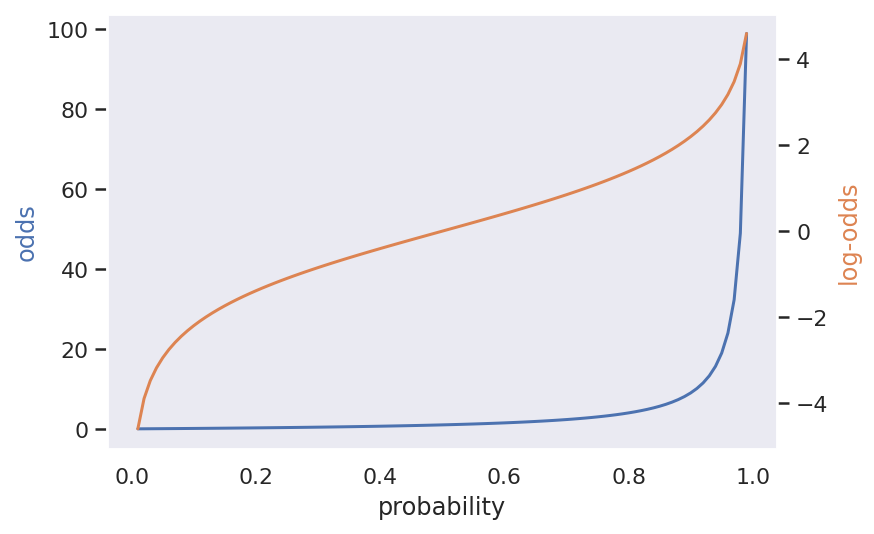

In [16]:
probability = np.linspace(0.01, 1, 100)
odds = probability / (1 - probability)

_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(probability, odds, 'C0')
ax2.plot(probability, np.log(odds), 'C1')

ax1.set_xlabel('probability')
ax1.set_ylabel('odds', color='C0')
ax2.set_ylabel('log-odds', color='C1')
ax1.grid(False)
ax2.grid(False)

Таким образом, значения коэффициентов, получаемых с помощью функции
summary, указываются в масштабе логарифмов шансов.

In [17]:
az.summary(trace_1, var_names=['alpha', 'beta'])

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha   -9.254  4.773 -18.024   -0.227      0.106    0.075    2018.0  2018.0   
beta[0]  4.705  0.918   3.095    6.463      0.022    0.015    1809.0  1809.0   
beta[1] -5.209  1.005  -7.004   -3.352      0.020    0.014    2543.0  2540.0   

         ess_bulk  ess_tail  r_hat  
alpha      2028.0    2130.0    1.0  
beta[0]    1744.0    1374.0    1.0  
beta[1]    2508.0    1963.0    1.0

In [18]:
logistic = lambda z: 1/(1 + np.exp(-z))

In [19]:
x_1 = 4.5 # sepal_length
x_2 = 3   # sepal_width

df = az.summary(trace_1, var_names=['alpha', 'beta'])
log_odds_versicolor_i = (df['mean'] * [1, x_1, x_2]).sum()
probability_versicolor_i = logistic(log_odds_versicolor_i)

log_odds_versicolor_f = (df['mean'] * [1, x_1 + 1, x_2]).sum()
probability_versicolor_f = logistic(log_odds_versicolor_f)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


In [20]:
log_odds_versicolor_f - log_odds_versicolor_i

4.705

In [21]:
probability_versicolor_f - probability_versicolor_i

0.7064421834647749

<AxesSubplot:>

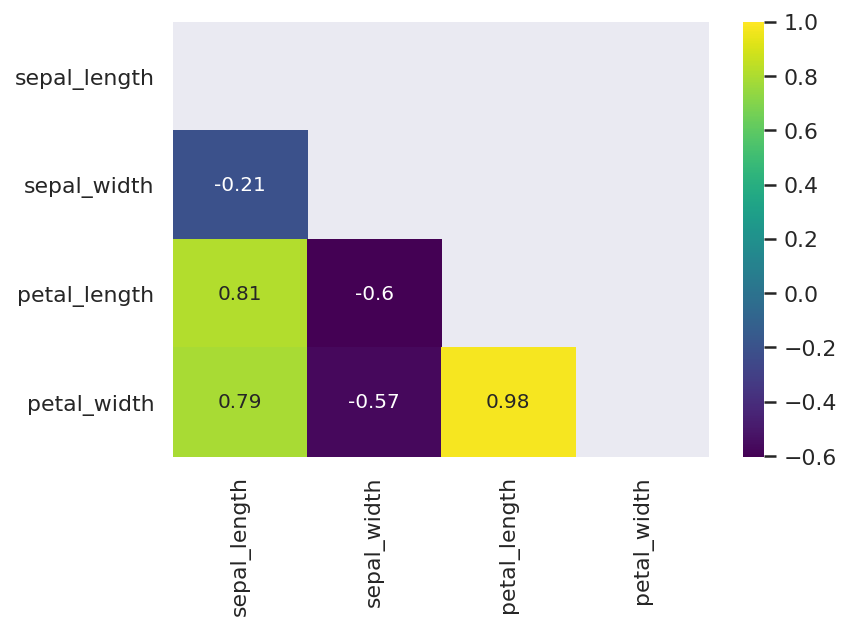

In [22]:
corr = iris[iris['species'] != 'virginica'].corr()
mask = np.tri(*corr.shape).T
sns.heatmap(corr, mask=mask, annot=True, cmap='viridis')

Одним из вариантов решения при обработке переменных с (сильной) корреляцией является простое удаление одной коррелирующей переменной (или нескольких коррелирующих переменных). 

Другой вариант – передача большего объема информации в априорное распределение. Этого можно достичь, используя информативные априорные распределения, если мы располагаем полезной информацией.

Для слабоинформативных априорных распределений Andrew Gelman рекомендует (https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations) масштабирование всех небинарных переменных для получения среднего значения 0 и последующего использования t-распределения Стьюдента.

$$\beta \sim StudentT(0, v, sd)$$
Стандартное отклонение $sd$ должно выбираться так, чтобы предоставлять минимальную (слабую) информацию об ожидаемых значениях при установленном масштабе.

Для параметра нормальности  $\nu$ предполагается значение в интервале 3–7. Такое априорное распределение в общем означает, что ожидаются малые значения коэффициентов, но при этом используется распределение с широкими хвостами, потому что могут встретиться и некоторые большие значения коэффициентов.

#### Несбалансированные классы

In [23]:
df = iris.query("species == ('setosa', 'versicolor')")
df = df[45:]
y_3 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width']
x_3 = df[x_n].values

In [24]:
with pm.Model() as model_3:
    
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    mu = alpha + pm.math.dot(x_3, beta)
    
    theta = 1/(1+pm.math.exp(-mu))
    bd = pm.Deterministic('bd',
                          -alpha/beta[1] - (beta[0]/beta[1])*x_3[:, 0])
    yl = pm.Bernoulli('yl', p=theta, observed=y_3)
    
    trace_3 = pm.sample(1000)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


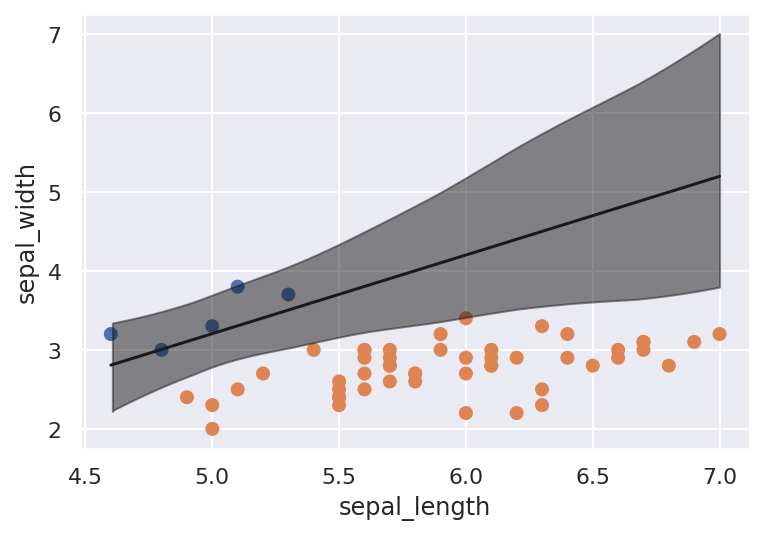

In [25]:
idx = np.argsort(x_3[:,0])
bd = trace_3['bd'].mean(0)[idx]
plt.scatter(x_3[:,0], x_3[:,1], c= [f'C{x}' for x in y_3])
plt.plot(x_3[:,0][idx], bd, color='k')

az.plot_hpd(x_3[:,0], trace_3['bd'], color='k')

plt.xlabel(x_n[0])
plt.ylabel(x_n[1])
plt.show()

In [26]:
az.summary(trace_3, var_names=['alpha', 'beta'])

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha   -4.464  5.650 -14.435    6.471      0.213    0.151     703.0   703.0   
beta[0]  3.244  0.948   1.483    5.071      0.038    0.027     618.0   618.0   
beta[1] -3.704  1.278  -6.176   -1.443      0.050    0.035     654.0   654.0   

         ess_bulk  ess_tail  r_hat  
alpha       704.0     830.0   1.01  
beta[0]     607.0     512.0   1.01  
beta[1]     644.0     661.0   1.01

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


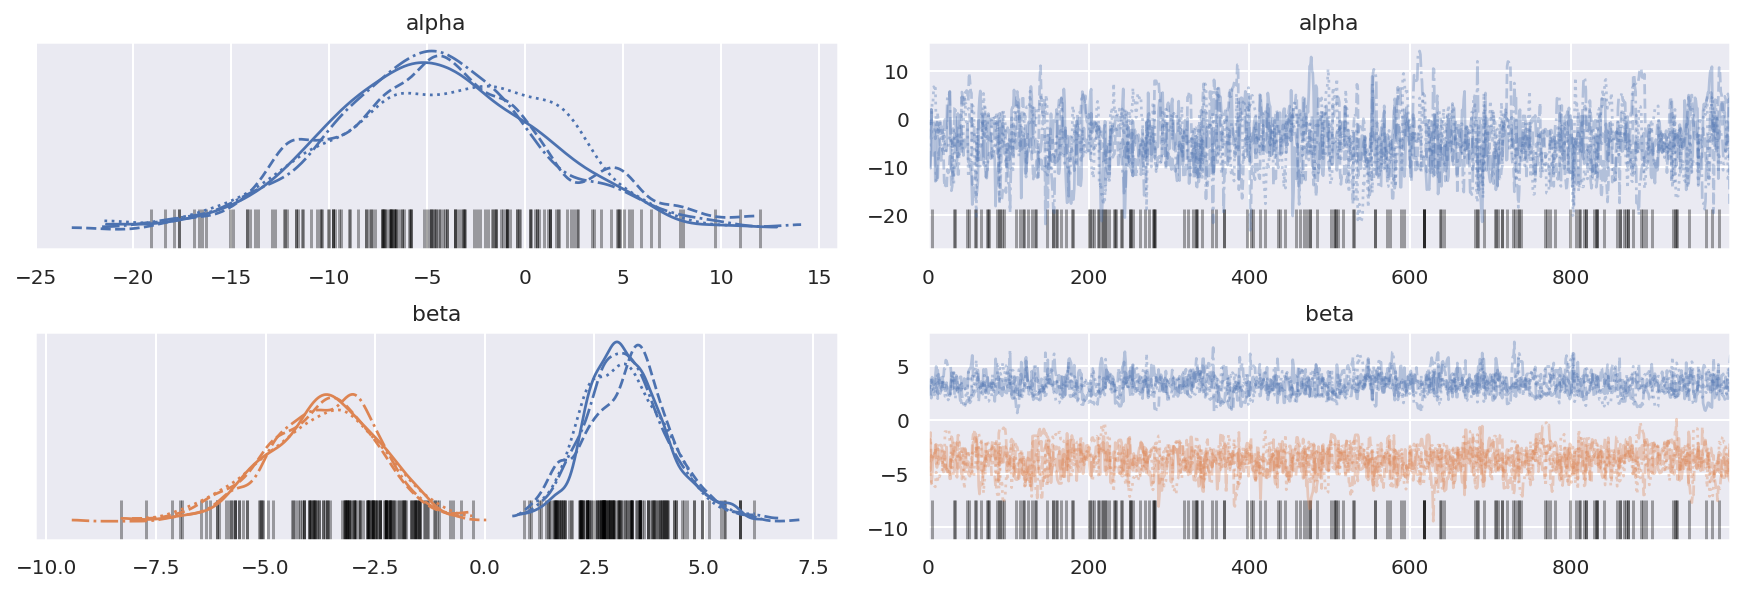

In [27]:
az.plot_trace(trace_3, var_names=['alpha', 'beta'])
plt.show()

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:1691: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
posterior predictive variable yl's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


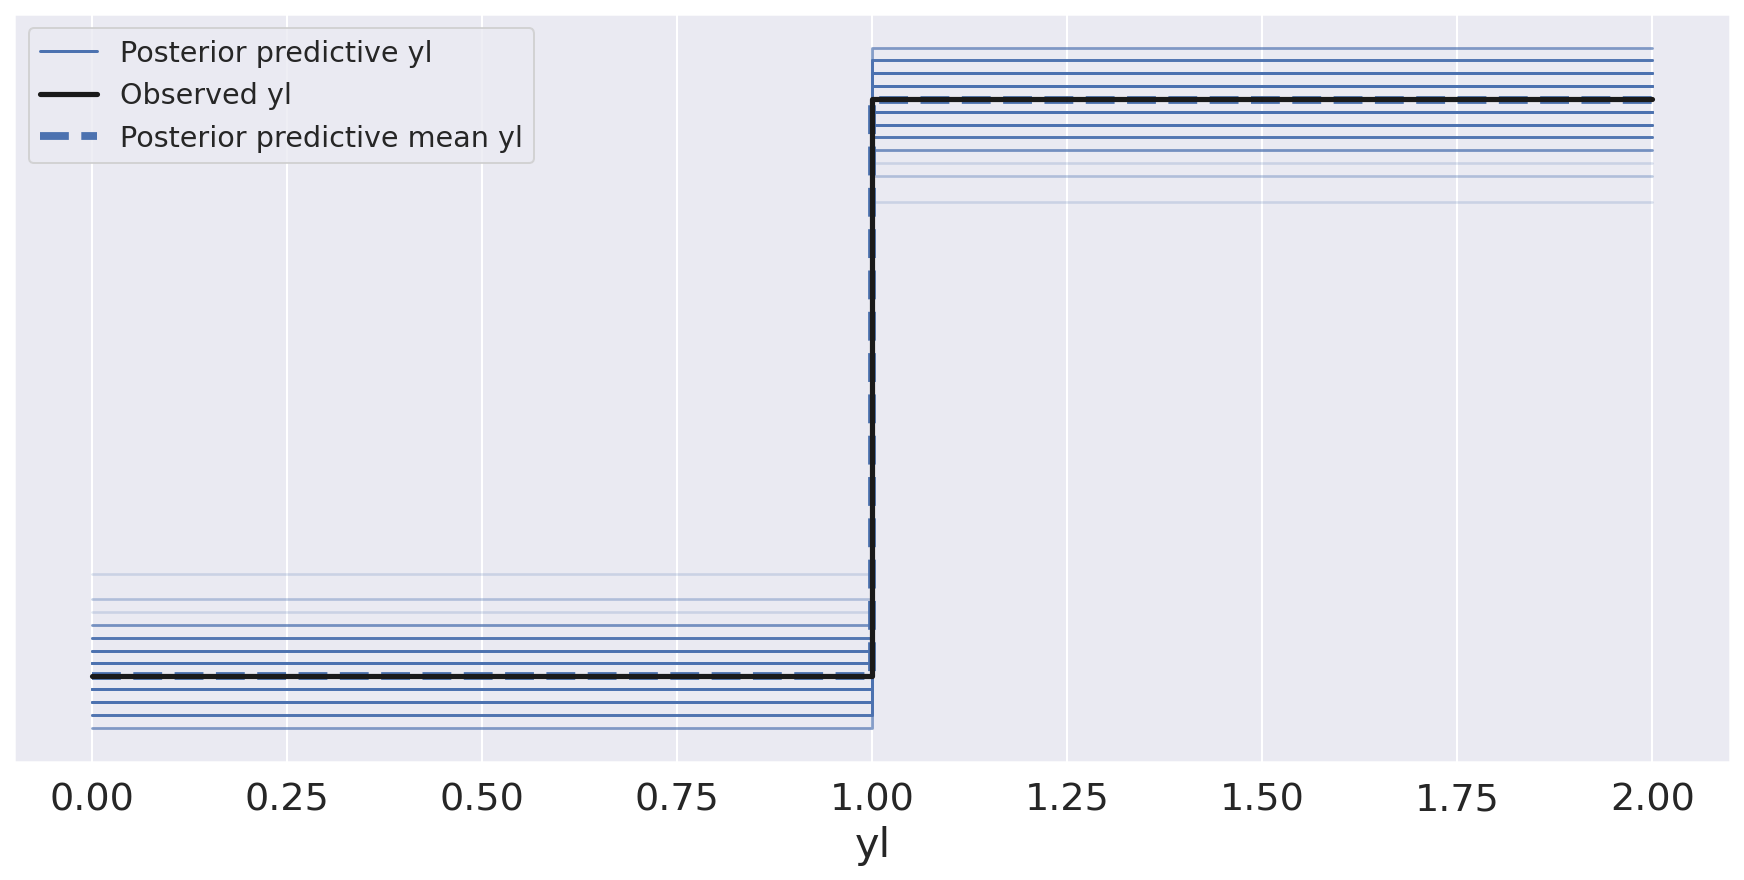

In [28]:
ppc = pm.sample_posterior_predictive(trace_3, 
                                     samples=200,
                                     model=model_3,
                                     random_seed=2)
data_ppc =az.from_pymc3(trace=trace_3, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

Обобщение логистической регрессии для более двух классов - softmax-функция.

$$softmax_i(\mu)=\frac{e^{\mu_i}}{\sum_k e^{\mu_k}}$$


Интересно, что функция softmax имеет ту же форму, что и распределение Больцмана, используемое в статистической механике – весьма значимом разделе физики, занимающимся вероятностным описанием атомных и молекулярных систем. 

Распределение Больцмана (и softmax в некоторых областях) имеет параметр, называемый температурой  $T$, на который делится $\mu$.
Когда $T->\infty$, распределение вероятностей становится плоским, равномерным и все состояния одинаково вероятны.
Когда $T->0$, заполняется только наиболее вероятное состояние, следовательно, softmax начинает вести себя как функция max.


Второе изменение заключается в замене распределения Бернулли на ка-
тегориальное распределение. 

Категориальное распределение – это обобщение распределения Бернулли для получения более двух выходных результатов. Кроме того, так же как распределение Бернулли (подбрасывание одной
монеты) представляет собой особый случай биномиального распределения
(подбрасывание n монет), так и категориальное распределение (один бросок
игральной кости) является особым случаем мультиноминального распреде-
ления (n бросков игральной кости).

In [29]:
iris = sns.load_dataset('iris')
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

In [30]:
from theano import tensor as tt

In [31]:
with pm.Model() as model_s:
    
    alpha = pm.Normal('alpha', mu=0, sd=5, shape=3)
    beta = pm.Normal('beta', mu=0, sd=5, shape=(4,3))
    mu = pm.Deterministic('mu', alpha + pm.math.dot(x_s, beta))
    
    theta = tt.nnet.softmax(mu)
    yl = pm.Categorical('yl', p=theta, observed=y_s)
    
    trace_s = pm.sample(2000)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.
There were 138 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [32]:
az.summary(trace_s, var_names=['alpha', 'beta'])

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
alpha[0]  -1.004  3.663  -7.290    6.477      0.063    0.045    3343.0   
alpha[1]   5.933  3.156   0.056   11.768      0.059    0.042    2830.0   
alpha[2]  -4.768  3.360 -10.990    1.791      0.062    0.044    2961.0   
beta[0,0] -2.568  4.072 -10.131    5.009      0.075    0.053    2966.0   
beta[0,1]  1.922  3.293  -4.116    8.166      0.076    0.053    1897.0   
beta[0,2]  0.567  3.324  -5.821    6.620      0.076    0.054    1908.0   
beta[1,0]  3.245  3.333  -2.949    9.690      0.074    0.053    2005.0   
beta[1,1] -0.877  3.021  -6.599    4.645      0.078    0.055    1502.0   
beta[1,2] -2.305  3.053  -8.053    3.437      0.078    0.055    1529.0   
beta[2,0] -6.277  4.330 -14.634    1.530      0.075    0.054    3367.0   
beta[2,1] -1.339  3.605  -8.034    5.450      0.072    0.051    2476.0   
beta[2,2]  7.887  3.796   1.091   15.294      0.074    0.052    2663.0   
beta[3,0] -5.713  4.341 -13.539    2.748      0.075    0.053    3361.0   
beta[3,1] -1.018  3.403  -6.971    5.668      0.072    0.051    2240.0   
beta[3,2]  6.821  3.542   0.198   13.491      0.076    0.054    2153.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
alpha[0]   3343.0    3338.0    3905.0    1.0  
alpha[1]   2827.0    2838.0    3872.0    1.0  
alpha[2]   2961.0    2961.0    3495.0    1.0  
beta[0,0]  2966.0    2972.0    2941.0    1.0  
beta[0,1]  1897.0    1903.0    3317.0    1.0  
beta[0,2]  1908.0    1905.0    2757.0    1.0  
beta[1,0]  2005.0    2004.0    3273.0    1.0  
beta[1,1]  1502.0    1500.0    2891.0    1.0  
beta[1,2]  1529.0    1523.0    2881.0    1.0  
beta[2,0]  3210.0    3362.0    3952.0    1.0  
beta[2,1]  2476.0    2477.0    2397.0    1.0  
beta[2,2]  2663.0    2664.0    3728.0    1.0  
beta[3,0]  3361.0    3353.0    3392.0    1.0  
beta[3,1]  2240.0    2237.0    2767.0    1.0  
beta[3,2]  2153.0    2155.0    2621.0    1.0

In [33]:
az.plot_trace(trace_s, var_names=['alpha', 'beta'])
plt.show()

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


In [34]:
data_pred = trace_s['mu'].mean(0)
y_pred = [np.exp(point)/np.sum(np.exp(point), axis=0) for point in data_pred]

In [35]:
# train accuracy
f'{np.sum(y_s == np.argmax(y_pred, axis=1)) / len(y_s):.2f}'

'0.98'

In [36]:
with pm.Model() as model_sf:
    
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=2)
    beta = pm.Normal('beta', mu=0, sd=2, shape=(4,2))
    alpha_f = tt.concatenate([[0], alpha])
    beta_f = tt.concatenate([np.zeros((4,1)) , beta], axis=1)
    mu = alpha_f + pm.math.dot(x_s, beta_f)
    
    theta = tt.nnet.softmax(mu)
    yl = pm.Categorical('yl', p=theta, observed=y_s)
    
    trace_sf = pm.sample(1000)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


Возникла та же проблема неидентифицируемости, с которой мы уже сталкивались при обработке коррелирующих данных в других моделях регрессии или при работе с абсолютно разделенными (непересекающимися)
классами. 

В этом случае слишком широкое апостериорное распределение является следствием условия, по которому все вероятности должны быть просуммированы, чтобы получить одно значение вероятности. Принимая это условие, мы используем больше параметров, чем необходимо для полного определения модели. Проще говоря, если имеется десять чисел, которые суммируются для получения одного результата, то мне необходимо передать только девять из них, десятое я могу вычислить. 

Вариантом решения этой проблемы является присваивание лишним параметрам некоторого фиксированного значения, например нуля.

In [37]:
az.summary(trace_sf, var_names=['alpha', 'beta'])

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
alpha[0]   2.647  0.847   1.007    4.171      0.018    0.014    2151.0   
alpha[1]  -2.361  1.099  -4.340   -0.266      0.024    0.017    2158.0   
beta[0,0]  2.113  1.118   0.039    4.194      0.027    0.020    1703.0   
beta[0,1]  1.629  1.164  -0.498    3.813      0.028    0.020    1671.0   
beta[1,0] -1.855  0.715  -3.148   -0.511      0.016    0.012    1935.0   
beta[1,1] -2.341  0.845  -3.895   -0.747      0.018    0.013    2127.0   
beta[2,0]  1.706  1.250  -0.470    4.208      0.029    0.021    1856.0   
beta[2,1]  5.435  1.477   2.825    8.320      0.031    0.022    2205.0   
beta[3,0]  1.161  1.224  -1.161    3.413      0.029    0.020    1796.0   
beta[3,1]  5.673  1.358   3.221    8.283      0.028    0.020    2409.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
alpha[0]   1962.0    2218.0    2020.0    1.0  
alpha[1]   2158.0    2159.0    1934.0    1.0  
beta[0,0]  1522.0    1738.0    2349.0    1.0  
beta[0,1]  1623.0    1671.0    2120.0    1.0  
beta[1,0]  1860.0    1959.0    2147.0    1.0  
beta[1,1]  2091.0    2115.0    2462.0    1.0  
beta[2,0]  1856.0    1854.0    2050.0    1.0  
beta[2,1]  2205.0    2213.0    2015.0    1.0  
beta[3,0]  1796.0    1795.0    2493.0    1.0  
beta[3,1]  2349.0    2405.0    2464.0    1.0

In [38]:
az.plot_trace(trace_sf, var_names=['alpha', 'beta'])
plt.show()

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


#### Порождающий классификатор. Пример LDA


Модели выше - дискриминативные, где вычисляется $p(y|x)$.

В порождающих классификаторах сначала моделируется
$p(x|y)$, то есть распределение x для каждого класса, затем данные распределяются по классам. Прмиер такой модель - LDA. Несмотря на характерное название, модель LDA является порождающей

In [39]:
with pm.Model() as lda:
    
    mu = pm.Normal('mu', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', 10)
    setosa = pm.Normal('setosa', mu=mu[0], sd=sigma, observed=x_0[:50])
    versicolor = pm.Normal('versicolor', mu=mu[1], sd=sigma, observed=x_0[:50])
    
    bd = pm.Deterministic('bd', (mu[0] + mu[1])/2 )
    trace_lda = pm.sample(1000)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [40]:
az.summary(trace_lda)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu[0]  5.006  0.051   4.913    5.103      0.001      0.0    5240.0  5237.0   
mu[1]  5.006  0.050   4.913    5.102      0.001      0.0    5486.0  5481.0   
sigma  0.357  0.026   0.311    0.405      0.000      0.0    4538.0  4421.0   
bd     5.006  0.035   4.943    5.074      0.000      0.0    5175.0  5175.0   

       ess_bulk  ess_tail  r_hat  
mu[0]    5241.0    2913.0    1.0  
mu[1]    5497.0    3029.0    1.0  
sigma    4669.0    2383.0    1.0  
bd       5186.0    3055.0    1.0

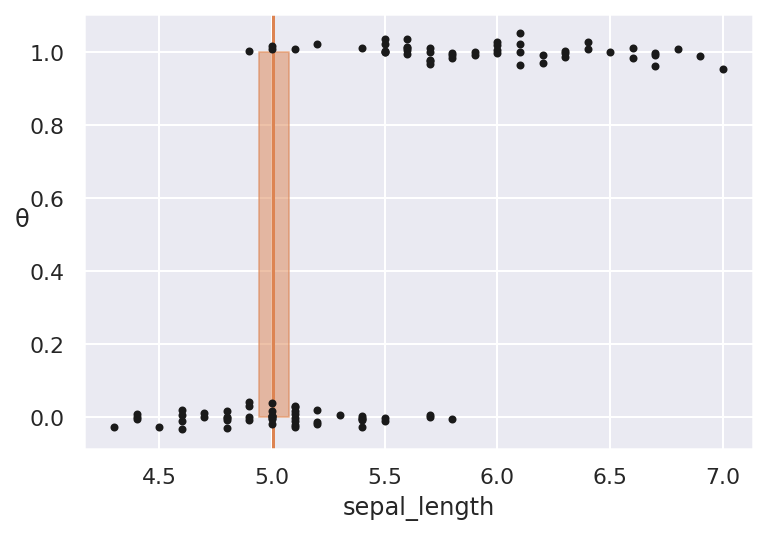

In [41]:
plt.axvline(trace_lda['bd'].mean(), ymax=1, color='C1')
bd_hpd = az.hdi(trace_lda['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C1', alpha=0.5)

plt.plot(x_0, np.random.normal(y_0, 0.02), '.', color='k')
plt.ylabel('θ', rotation=0)
plt.xlabel('sepal_length')
plt.show()

Линейную дискриминантную модель можно расширить для использования более одного признака, если моделировать классы как многомерные
гауссовы распределения. Кроме того, можно сделать менее строгим предварительное предположение о том, что все классы совместно используют общую дисперсию (или ковариацию). В результате мы приходим к модели квадратичного линейного дискриминантного анализа.


В общем модели LDA и QDA работают лучше, чем логистическая регрессия,
когда используемые признаки являются более или менее распределенными
по Гауссу, в противном случае более эффективна логистическая регрессия. Одним из преимуществ порождающей модели для классификации является то, что в нее проще и естественнее вводится априорная информация.

---

#### Poisson regression

Модель предполагает, что целевая переменная имеет распределение Пуассона.

Один из вариантов полезного применения дискретного распределения Пуассона – подсчет объектов, например: количество частиц при распаде радиоактивных ядер, количество детей у супружеской пары, количество подписчиков в «Твиттере». Т.е. работа осуществляется со счетными данными, дискретными неотрицательными числами.

Вообще, распределение Пуассона применяется для описания вероятности определенного числа событий, возникающих в фиксированном временном или пространственном интервале. Таким образом, распределение Пуассона предполагает, что __события происходят независимо друг от друга__ и __возникают в строго определенном интервале времени и/или пространства__.

Функция вероятностей:

$$f(x|\mu)=\frac{e^{-\mu}\mu^x}{x!}$$

где $\mu$-среднее число событий в единицу времени/элементов в рамках единицы пространства.

In [42]:
mu_params = [0.5, 1.5, 3, 8]
x = np.arange(0, max(mu_params) * 3)
for mu in mu_params:
    y = stats.poisson(mu).pmf(x)
    plt.plot(x, y, 'o-', label=f'μ = {mu:3.1f}')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

Распределение Пуассона можно рассматривать как специальный случай для биномиального распределения в случае большого $n$ и небольшой вероятности положительного исхода $p$, приближенно в таком случае:

$$np\simeq np(1-p)$$
т.е.:
$$E[x] \simeq V[x]$$

Соответственно, можно сказать, что переменная $x$ имеет распределение Пуассона:
$$x \sim Poisson(\mu=np)$$

При подсчете объектов одним из возможных вариантов является отсутствие объекта счета, то есть получение нулевого значения.

При использовании распределения Пуассона можно заметить, например, при выполнении проверки прогнозируемого апостериорного распределения, что модель генерирует меньше нулей по сравнению со значимыми данными.


Подойти к исправлению этого момента можно с разных сторон.
Чаще всего применяется вариант, при котором для конкретных целей достаточно предположить, что наблюдается смешанное выполнение двух процессов:

1. Процесс, моделируемый с распределением Пуассона с вероятностью $\psi$.
2. Процесс, генерирующий нули с вероятностью 1-$\psi$.

Такая модель называется ZIP (zero-inflated Poisson).

Соответственно, распределение ZIP-модели:

$$P(y_j=0)=1-\psi + \psi(e^{-\mu})$$
$$P(y_j=k_i)=\psi\frac{\mu^{x_i}e^{-\mu}}{x_i!}$$

In [43]:
n = 100
θ_real = 2.5
psi = 0.1
# Имитация некоторых случайных данных
counts = np.array([(np.random.random() > (1-psi)) * np.random.poisson(θ_real) for i in range(n)])

In [44]:
with pm.Model() as ZIP:
    
    psi = pm.Beta('psi', 1, 1)
    theta = pm.Gamma('theta', 2, 0.1)
    y = pm.ZeroInflatedPoisson('y', psi, theta, observed=counts)
    
    trace = pm.sample(1000)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, psi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [45]:
az.summary(trace)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
psi    0.176  0.042   0.098    0.251      0.001    0.001    3045.0  3045.0   
theta  2.305  0.431   1.517    3.079      0.007    0.005    3318.0  3318.0   

       ess_bulk  ess_tail  r_hat  
psi      2860.0    1966.0    1.0  
theta    3284.0    2712.0    1.0

In [49]:
az.plot_trace(trace)
plt.show()

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Моделируя $\mu$ как линейную комбинацию от некоторых факторов, мы можем получить регрессию Пуассона с дополнительными нулевыми значениями.

Для примера реализации модели Пуассона с дополнением нулевыми значениями будем работать с набором данных, предоставляемым отделением калифорнийского университета в Лос-Анджелесе Institute for Digital Research and Education (http://www.ats.ucla.edu/stat/data).

In [46]:
fish_data = pd.read_csv('data/fish.csv')

In [47]:
fish_data.describe()

nofish    livebait      camper    persons       child          xb  \
count  250.000000  250.000000  250.000000  250.00000  250.000000  250.000000   
mean     0.296000    0.864000    0.588000    2.52800    0.684000    0.973796   
std      0.457407    0.343476    0.493182    1.11273    0.850315    1.440277   
min      0.000000    0.000000    0.000000    1.00000    0.000000   -3.275050   
25%      0.000000    1.000000    0.000000    2.00000    0.000000    0.008267   
50%      0.000000    1.000000    1.000000    2.00000    0.000000    0.954550   
75%      1.000000    1.000000    1.000000    4.00000    1.000000    1.963855   
max      1.000000    1.000000    1.000000    4.00000    3.000000    5.352674   

               zg       count  
count  250.000000  250.000000  
mean     0.252323    3.296000  
std      2.102391   11.635028  
min     -5.625944    0.000000  
25%     -1.252724    0.000000  
50%      0.605079    0.000000  
75%      1.993237    2.000000  
max      4.263185  149.000000

In [51]:
fish_data.head()

nofish  livebait  camper  persons  child        xb        zg  count
0       1         0       0        1      0 -0.896315  3.050405      0
1       0         1       1        1      0 -0.558345  1.746149      0
2       0         1       0        1      0 -0.401731  0.279939      0
3       0         1       1        2      1 -0.956298 -0.601526      0
4       0         1       0        1      0  0.436891  0.527709      1

In [71]:
fish_data.nunique()

nofish        2
livebait      2
camper        2
persons       4
child         4
xb          250
zg          250
count        25
dtype: int64

Попробуем построить модель, которая предсказывает количество пойманной рыбы в зависимости от количества взятых с собой детей и наличии/отсутствии спальных мешков.

In [69]:
with pm.Model() as zip_reg:
    
    psi = pm.Beta('psi', 1, 1)
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    theta = pm.math.exp(alpha + beta[0]*fish_data['child'] + beta[1]*fish_data['camper'])
    
    yl = pm.ZeroInflatedPoisson('yl', psi, theta, observed=fish_data['count'])
    trace_zip_reg = pm.sample(1000)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, psi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8873407727557097, but should be close to 0.8. Try to increase the number of tuning steps.


In [72]:
az.summary(trace_zip_reg)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha    1.613  0.085   1.457    1.772      0.002    0.001    1639.0  1639.0   
beta[0] -0.932  0.098  -1.110   -0.741      0.002    0.001    3343.0  3268.0   
beta[1]  0.806  0.094   0.627    0.982      0.002    0.002    1735.0  1709.0   
psi      0.487  0.036   0.417    0.550      0.001    0.000    2898.0  2887.0   

         ess_bulk  ess_tail  r_hat  
alpha      1646.0    1961.0    1.0  
beta[0]    3339.0    2527.0    1.0  
beta[1]    1747.0    2163.0    1.0  
psi        2899.0    2729.0    1.0

In [76]:
children = [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []

for n in children:
    without_camper = trace_zip_reg['alpha'] + trace_zip_reg['beta'][:,0] * n
    with_camper = without_camper + trace_zip_reg['beta'][:,1]
    fish_count_pred_0.append(np.exp(without_camper))
    fish_count_pred_1.append(np.exp(with_camper))
    
plt.plot(children, fish_count_pred_0, 'C0.', alpha=0.01)
plt.plot(children, fish_count_pred_1, 'C1.', alpha=0.01)

plt.xticks(children)
plt.xlabel('Number of children')
plt.ylabel('Fish caught')
plt.plot([], 'C0o', label='without camper')
plt.plot([], 'C1o', label='with camper')
plt.legend()
plt.show()

Соответственно, исходя из предварительных соображений и модели, мы можем сделать следующие выводы:

1. С каждым дополнительным ребенком в походе ожидаемое среднее число пойманной рыбы снижается в $e^{-0.932} \simeq 0.4$
2. Наличие спального мешка увеличивает ожидаемое среднее число пойманной рыбы в $e^{0.806} \simeq 2.2$

---

#### Robust logistic regression

Похожая методика по доабвлению избыточных нулевых значений без прямого моделирования фактора, 
порождающего эту проблему, предложенная Крушке (Kruschke), может применяться для увеличения
робастности логистичекой регрессии.

Для примера добавим несколько точек данных с существенно отличающимся диапазоном значений факторов и соответствующих им классов 

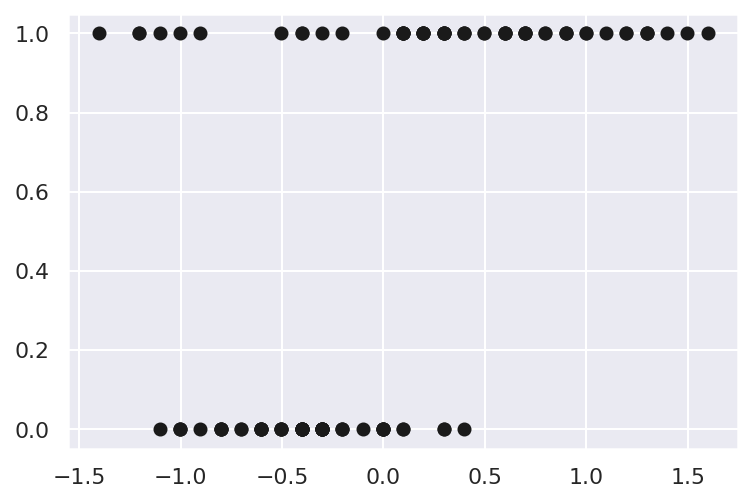

In [107]:
iris = sns.load_dataset("iris")
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length'
x_0 = df[x_n].values
y_0 = np.concatenate((y_0, np.ones(6, dtype=int)))
x_0 = np.concatenate((x_0, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4]))
x_c = x_0 - x_0.mean()
plt.plot(x_c, y_0, 'o', color='k');

Здесь мы получили несколько ирисов многоцветных (значения 1) с преднамеренно укороченной (то есть неправильной) длиной чашелистика.

Исправить возникшую проблему можно с помощью модели смеси распределений:

Мы предполагаем, что
1. С вероятностью $\pi$ значения классов в данных получены случайным образом.
2. С вероятностью $1-\pi$ значения классов в данных моделируются логистической регрессией.

$$p=\pi0.5+(1-\pi)logistic(\alpha+X\beta)$$

In [102]:
with pm.Model() as model_rlg:
    
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    mu = alpha + x_c*beta
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    bd = pm.Deterministic('bd', -alpha/beta)
    
    pi = pm.Beta('pi', 1, 1)
    p = pi*0.5 + (1-pi)*theta
    yl = pm.Bernoulli('yl', p=p, observed=y_0)
    
    trace_rlg = pm.sample(1000)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


In [103]:
az.summary(trace_rlg, var_names=['alpha', 'beta', 'bd', 'pi'])

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha  -0.819  0.918  -2.551    0.870      0.022    0.017    1703.0  1422.0   
beta   15.913  6.444   5.375   27.453      0.168    0.122    1466.0  1384.0   
bd      0.050  0.056  -0.058    0.160      0.001    0.001    2351.0  2351.0   
pi      0.298  0.077   0.158    0.441      0.002    0.001    2022.0  2022.0   

       ess_bulk  ess_tail  r_hat  
alpha    1766.0    1745.0    1.0  
beta     1534.0    2000.0    1.0  
bd       2402.0    2172.0    1.0  
pi       1943.0    1583.0    1.0

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/stats/stats.py:341: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


<function matplotlib.pyplot.show(close=None, block=None)>

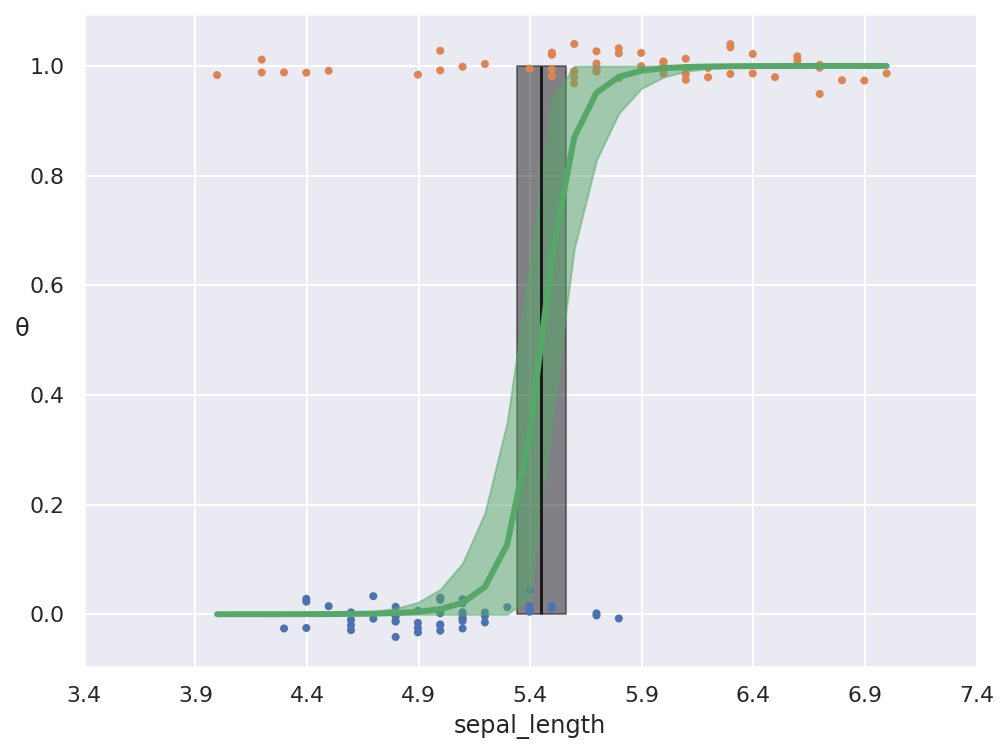

In [118]:
theta = trace_rlg['theta'].mean(axis=0)
idx = np.argsort(x_c)

fig = plt.figure(figsize=(8,6))
plt.plot(x_c[idx], theta[idx], color='C2', lw=3);
plt.vlines(trace_rlg['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hpd(trace_rlg['bd'])

plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_0, 0.02), marker='.', color=[f'C{x}' for x in y_0])
theta_hpd = az.hpd(trace_rlg['theta'])[idx]
plt.fill_between(x_c[idx], theta_hpd[:,0], theta_hpd[:,1], color='C2', alpha=0.5)

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks() 
plt.xticks(locs, np.round(locs + x_0.mean(), 1))
plt.show

Сравним погонку параметров первоначальной модели логистической регрессии и модели робастной с дополнительным шумом в данных:

In [124]:
df1 = az.summary(trace_0, var_names=['alpha', 'beta', 'bd'])
df1['model'] = 'basic_logreg'
df2 = az.summary(trace_rlg, var_names=['alpha', 'beta', 'bd'])
df2['model'] = 'robust_logreg'

df1 = df1.append(df2)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


In [125]:
df1

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha   0.302  0.341  -0.328    0.944      0.006    0.005    3048.0  2190.0   
beta    5.373  1.069   3.484    7.366      0.020    0.015    2759.0  2628.0   
bd     -0.055  0.062  -0.169    0.064      0.001    0.001    3081.0  2464.0   
alpha  -0.819  0.918  -2.551    0.870      0.022    0.017    1703.0  1422.0   
beta   15.913  6.444   5.375   27.453      0.168    0.122    1466.0  1384.0   
bd      0.050  0.056  -0.058    0.160      0.001    0.001    2351.0  2351.0   

       ess_bulk  ess_tail  r_hat          model  
alpha    3072.0    2372.0    1.0   basic_logreg  
beta     2818.0    2197.0    1.0   basic_logreg  
bd       3086.0    2547.0    1.0   basic_logreg  
alpha    1766.0    1745.0    1.0  robust_logreg  
beta     1534.0    2000.0    1.0  robust_logreg  
bd       2402.0    2172.0    1.0  robust_logreg

Как видно по гарфикам, разделяющие гиперплоскости довольно похожи, а коэффициенты уравнения регрессии уже существенно отличаются у робастной модели ввиду дополнительной зашумленности данных.

#### GLM модуль

PyMC3 дополнительно предоставляет общий API для создания GLM-моделей:

Линейная регрессия:


    with pm.Model() as model:
    glm.glm('y ~ x', data)
    trace = sample(2000)


Еще одно полезное расширение, которое можно интерпретировать как ком-
бинированное, – отрицательное биномиальное распределение – в этом случае объединяются распределения Пуассона,где $\mu$ является
случайной переменной с гамма-распределением. Отрицательное биномиальное распределение – полезная альтернатива распределению Пуассона, когда исследуются данные с очень большим разбросом (дисперсией), то есть для таких данных дисперсия больше их среднего значения.